# Survival CNN

Using CNN to exploit CT scans and predict survival time thanks to a Cox model 

The idea is to extract features from the images using resnet18 pretrained. We will then use these features in a CoxPH model (DeepSurv).

In [37]:
from utils import *
from sklearn.model_selection import train_test_split
from torch import nn
import torch
import pandas as pd
import torchvision.models as models
from pycox.models import CoxPH
import torchtuples as tt
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
working_dir = %pwd
data_path = working_dir.replace('/notebooks', '/challenge_files')
train_images_path = f'{data_path}/x_train/images'
test_images_path = f'{data_path}/x_test/images'

For each patient, we have a a 3d scan and a 3d mask. To use resnet, we must extract a 2d slice from those 3d images. We decided to extract the slice that contains the biggest tumor surface (see utils.py)

In [40]:
index, train_images = create_image_inputs(train_images_path) 
index_, test_images = create_image_inputs(test_images_path)
len(train_images), train_images[0].shape

(300, torch.Size([1, 3, 448, 224]))

In [4]:
train_outputs = pd.read_csv(data_path + '/y_train/output_VSVxRFU.csv', index_col=0).to_numpy()

### Extracting features 

As explained before, we use resnet18 pretrained to extract relevant features from the images. 

Resnet is usually used for classification, so we make sure tu remove the classification head from the model.

In [5]:
resnet = models.resnet18(pretrained = True)
resnet_feat = nn.Sequential(*list(resnet.children())[:-1])

In [8]:
train_features = []
test_features = []
for img in train_images:
    with torch.no_grad():
        features = resnet_feat(img)
        train_features.append(features[0,:,0,0].numpy())
        
for img in test_images:
    with torch.no_grad():
        features = resnet_feat(img)
        test_features.append(features[0,:,0,0].numpy())

In [47]:
# Normalizing the features
scaler = StandardScaler()
input_features = scaler.fit_transform(train_features).astype(np.float32)

In [10]:
train_outputs = np.array(train_outputs)
train_features = np.array(train_features)

trainX, valX, trainY, valY = train_test_split(train_features, train_outputs, test_size=0.2)

trainY = (trainY[:,0], trainY[:,1])
valY = (valY[:,0], valY[:,1])
val = (valX, valY)
print(trainX.shape)
print(valX.shape)

(240, 512)
(60, 512)


### CoxPH (DeepSurv) model

Since resnet extracts 512 and we dont have a lot of samples, we expect to have a lot of overfitting so we added a lot of dropout and batchnorm layers to try to limit overfitting. 

In [28]:
net = nn.Sequential(
    nn.Linear(in_features=512, out_features=256),
    nn.Dropout(0.7),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(in_features=256, out_features=128),
    nn.Dropout(0.6),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(in_features=128, out_features=64),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(in_features=64, out_features=1)
)

model = CoxPH(net, tt.optim.SGD())

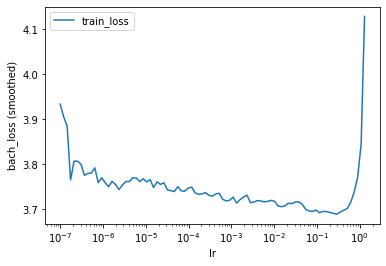

In [29]:
batch_size = 64
lrfinder = model.lr_finder(trainX, trainY, batch_size, tolerance=10)
_ = lrfinder.plot()

In [30]:
lrfinder.get_best_lr()

0.029150530628251937

In [31]:
model.optimizer.set_lr(0.01)

In [32]:
epochs = 300
callbacks = [tt.callbacks.EarlyStopping()]
#callbacks = []
verbose = True

In [33]:
%%time
log = model.fit(trainX, trainY, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 3.7489,	val_loss: 3.7002
1:	[0s / 0s],		train_loss: 3.6688,	val_loss: 3.7002
2:	[0s / 0s],		train_loss: 3.6191,	val_loss: 3.7004
3:	[0s / 0s],		train_loss: 3.6914,	val_loss: 3.6999
4:	[0s / 0s],		train_loss: 3.6030,	val_loss: 3.6989
5:	[0s / 0s],		train_loss: 3.7374,	val_loss: 3.6995
6:	[0s / 0s],		train_loss: 3.5618,	val_loss: 3.6996
7:	[0s / 0s],		train_loss: 3.6489,	val_loss: 3.6997
8:	[0s / 0s],		train_loss: 3.5908,	val_loss: 3.6999
9:	[0s / 0s],		train_loss: 3.6539,	val_loss: 3.7010
10:	[0s / 0s],		train_loss: 3.6094,	val_loss: 3.7000
11:	[0s / 0s],		train_loss: 3.5815,	val_loss: 3.7005
12:	[0s / 0s],		train_loss: 3.6018,	val_loss: 3.7010
13:	[0s / 0s],		train_loss: 3.5512,	val_loss: 3.6991
14:	[0s / 0s],		train_loss: 3.5917,	val_loss: 3.6995
CPU times: user 934 ms, sys: 3.96 ms, total: 938 ms
Wall time: 482 ms


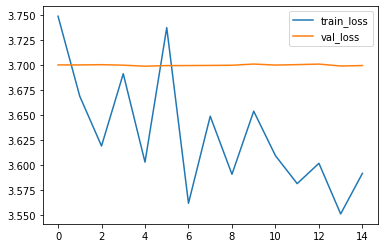

In [34]:
_ = log.plot()

The losses are not ideal... It may be due to overfitting but we are not unfortunately not able to have better curves

## Predictions

In [35]:
scaler = StandardScaler()
test_features = scaler.fit_transform(test_features).astype(np.float32)

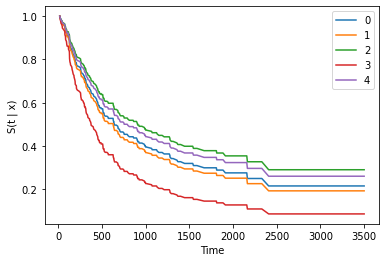

In [38]:
_ = model.compute_baseline_hazards()
pred = model.predict_surv_df(test_features)
pred.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

This graph is a visualization of the chances of surviving depending on the time for the first 5 patients. 

In [39]:
pred

0         1         2         3         4         5    \
duration                                                               
20        1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
24        0.995028  0.994668  0.995995  0.992052  0.995642  0.995941   
25        0.990060  0.989341  0.991989  0.984133  0.991284  0.991881   
31        0.985096  0.984021  0.987982  0.976245  0.986928  0.987820   
33        0.980135  0.978707  0.983974  0.968387  0.982572  0.983759   
...            ...       ...       ...       ...       ...       ...   
2600      0.214538  0.191833  0.289565  0.085066  0.259550  0.284753   
3078      0.214538  0.191833  0.289565  0.085066  0.259550  0.284753   
3222      0.214538  0.191833  0.289565  0.085066  0.259550  0.284753   
3251      0.214538  0.191833  0.289565  0.085066  0.259550  0.284753   
3500      0.214538  0.191833  0.289565  0.085066  0.259550  0.284753   

               6         7         8         9    ...       115       116  \
duration                                          ...                       
20        1.000000  1.000000  1.000000  1.000000  ...  1.000000  1.000000   
24        0.993636  0.995041  0.993744  0.995681  ...  0.993526  0.994151   
25        0.987285  0.990086  0.987500  0.991363  ...  0.987066  0.988311   
31        0.980949  0.985135  0.981270  0.987045  ...  0.980622  0.982481   
33        0.974627  0.980188  0.975053  0.982728  ...  0.974193  0.976661   
...            ...       ...       ...       ...  ...       ...       ...   
2600      0.139226  0.215421  0.143974  0.262730  ...  0.134550  0.163383   
3078      0.139226  0.215421  0.143974  0.262730  ...  0.134550  0.163383   
3222      0.139226  0.215421  0.143974  0.262730  ...  0.134550  0.163383   
3251      0.139226  0.215421  0.143974  0.262730  ...  0.134550  0.163383   
3500      0.139226  0.215421  0.143974  0.262730  ...  0.134550  0.163383   

               117       118       119       120       121       122  \
duration                                                               
20        1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
24        0.994187  0.995647  0.994689  0.993149  0.993925  0.994584   
25        0.988383  0.991295  0.989384  0.986316  0.987862  0.989176   
31        0.982589  0.986944  0.984085  0.979502  0.981810  0.983774   
33        0.976804  0.982594  0.978792  0.972706  0.975770  0.978378   
...            ...       ...       ...       ...       ...       ...   
2600      0.165227  0.259998  0.193118  0.119676  0.152335  0.186950   
3078      0.165227  0.259998  0.193118  0.119676  0.152335  0.186950   
3222      0.165227  0.259998  0.193118  0.119676  0.152335  0.186950   
3251      0.165227  0.259998  0.193118  0.119676  0.152335  0.186950   
3500      0.165227  0.259998  0.193118  0.119676  0.152335  0.186950   

               123       124  
duration                      
20        1.000000  1.000000  
24        0.993684  0.989734  
25        0.987381  0.979530  
31        0.981092  0.969390  
33        0.974816  0.959312  
...            ...       ...  
2600      0.141317  0.041308  
3078      0.141317  0.041308  
3222      0.141317  0.041308  
3251      0.141317  0.041308  
3500      0.141317  0.041308  

[225 rows x 125 columns]

This model returns the probability of surviving depending on time for each patient. To extract the survival time from this information, we decided to select the day at which the patient has less than 50% chance of surviving. 

In [45]:
result = pd.DataFrame(index=index_, columns=['SurvivalTime', 'Event'])
result.index.name = 'PatientID'
i = 0
for ind, row in result.iterrows():
    for index, value in pred[i].items():
        if value<0.5 or index==3500:
            row['SurvivalTime'] = index
            row['Event'] = 'nan'
            break
    i+=1
result

SurvivalTime Event
PatientID                   
207                646   nan
245                632   nan
220                911   nan
219                379   nan
413                799   nan
...                ...   ...
319                454   nan
339                512   nan
419                575   nan
274                476   nan
191                303   nan

[125 rows x 2 columns]

In [46]:
result.to_csv(working_dir.replace('/notebooks', '/results/output_CNN.csv'))

### Result : 

C_index on test set = 0.62. It is not too bad considering the problems we had with overfitting, but not the best compared to other methods we tried.